# Hawkes Processes for earnings
This notebook investigates how earnings reports change the parameters of the Hawkes processes fitting the motion of different Technology stocks. 

Implementation 1 shows a single-variable Hawkes process with a power law kernel, which works but is not applicable to the dataset.

Implementation 2 shows a bivariate Hawkes process (+ and - movements) with an exponential kernel. The code is vectorized and runs fast. It is applicable to the data as it considers the size of the movements (marks) when determining how the event changes the process' intensity.

Later, I will add a second kernel explaining changes in the point process due to preplanned corperate news releases, such as earnings.

I will use this model to value near-term OOTM options around corperate events via simulation.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone, datetime, timedelta
import requests
import sys
from scipy.optimize import minimize, SR1, Bounds
import finnhub


## Quick look at datasource (FinnHub API)

Showing what data is available for the stocks. Skip forward for Hawkes Processes.

In [2]:
# my finhub API token
token = 'bsoarofrh5re01t4f9a0'
finnhub_client = finnhub.Client(api_key=token)

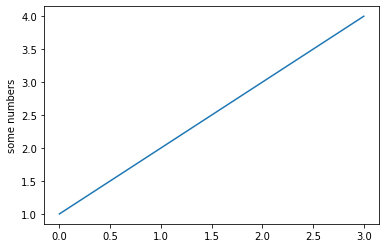

In [3]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

In [ ]:

df = pd.DataFrame(finnhub_client.company_basic_financials('AAPL', 'margin'))
df.head()

In [ ]:
d = finnhub_client.company_executive('AAPL')
df = pd.DataFrame(d['executive'])
df.head()

In [ ]:
print(finnhub_client.company_peers('AAPL'))

In [ ]:
d = finnhub_client.financials_reported(symbol='AAPL')
df = pd.DataFrame(d['data'])

In [ ]:
finnhub_client.company_profile(symbol='AAPL')

In [ ]:
import time

d = finnhub_client.etfs_holdings('SPY')
df = pd.DataFrame(d['holdings'])
profiles = []
for symbol in df['symbol']:
  profiles.append(finnhub_client.company_profile(symbol=symbol))
  time.sleep(1)
  print("added:",symbol)

In [ ]:
df['gsector'] = [profiles[i]['gsector'] for i in range(len(profiles))]
df.head()

In [ ]:
df['profiles'] = profiles
df.head()

In [ ]:
# get data for S&P companies
d = finnhub_client.etfs_holdings('SPY')
df = pd.DataFrame(d['holdings'])
df2 = pd.DataFrame()
for i in range(len(profiles)):
  df2 = df2.append(pd.DataFrame(list([profiles[i].values()]), columns=list(profiles[i].keys())))
df2['symbol'] = df2['ticker']
df2 = df2.drop('ticker', axis=1)
df3 = df.merge(df2, on='symbol')

In [ ]:
#df3.to_csv('./SP500_info.csv')

## Hawkes Processes

In the following section, I fit constraints on a Hawkes process using a quasi-Newton optimization.

To confirm that the determined parameters fit the dataset, I will use parametric bootstrapping. 


I approximate a power law as the sum of exponential functions with power-law weights, to use a recurrence relation that reduces the log-likelihood calculation from $O(N^2)$ to $O(N)$.

$\phi_{PL} (\tau | n, \epsilon, \tau _0) = \frac{n}{Z} \left( \Sigma _{i=0}^{M-1} \left( \frac{1}{\xi _i} \right) ^{1 + \epsilon} e^{-\tau / \xi_i} - S e ^{- \tau / \xi_{-1}} \right)$

for $\xi_i = \tau_0 m^i$ where $-1 \le i \lt M$

Parameter Z makes sure $\int_0^\infty \phi_{PL} (\tau) d\tau = n$ and $S$ makes sure that $\phi_{PL} (0) = 0$, as market participants can only react to events after more than 0 seconds.

In [ ]:
resol = 5
start = datetime(2020, 1, 1).replace(tzinfo=timezone.utc).timestamp()
end = datetime(2020, 7, 1).replace(tzinfo=timezone.utc).timestamp()

def get_stock_data(ticker, start = start, end = end, resolution = resol):
  """ for stock symbol, get data
  @param ticker (str): ticker symbol
  @param start: start date as unix timestamp or datetime
  @param end: end date as unix timestamp or datetime
  @param resolution (int): time resolution of data
  @returns: Pandas DataFrame of stock data
  """
  # convert to unix time stamp
  if start is datetime:
    start = start.replace(tzinfo=timezone.utc).timestamp()
  if end is datetime:
    end = end.replace(tzinfo=timezone.utc).timestamp()
  
  # Stock candles
  res = finnhub_client.stock_candles(ticker, resolution, start, end)
  try: return pd.DataFrame(res)
  except: return pd.DataFrame()

def get_df(df, resolution = resol):
  """ Cleans data from API into form interpretable for Hawkes Process
  @param df: output from get_stock_data() function
  @returns: pd DataFrame ready for analysis
  """
  df = df.drop(columns=['c','h','l'])
  df['diff'] = np.log(df['o']/df['o'].shift(1))
  df['date'] = df['t'].apply(lambda x: datetime.fromtimestamp(x))
  df['date'] = df['date'].apply(lambda x: x - timedelta(seconds = np.random.uniform(0,resolution*60)))
  df['dt'] = df['date'] - df['date'].shift(1)
  df['dt'] = df['dt'].apply(lambda x: x.total_seconds() / 100)

  # check that data import was mostly valid
  len_before = df.shape[0]
  df = df.drop(df.loc[df['s'] != 'ok'].index, axis = 0)
  if ( ((len_before - df.shape[0])/len_before) > .1 ):
    raise ValueError("Over 10% of dataframe returned NA")
  df = df.drop(columns = ['s','t','o'])
  df = df.reset_index(drop=True)

  # remove changes between days (will model those differently)
  df = df.drop(df.loc[df['dt'] > 100].index, axis=0).iloc[1:]
  df = df.reset_index(drop=True)

  # get only top 20% of movements
  q1 = df['diff'].quantile(q=.1)
  q2 = df['diff'].quantile(q=.9)

  # create mask for top 20% movement
  df['event'] = 0
  df.loc[(df['diff'] < q1) | (df['diff'] > q2), 'event'] = 1

  # get time elapsed
  df['time_elapsed'] = 0
  prev = 0
  for i in range(1,df.shape[0]):
    prev += df.loc[i, 'dt']
    df.loc[i, 'time_elapsed'] = prev
  
  # mark positive movements
  df['pos'] = 0
  df.loc[df['diff'] > 0, 'pos'] = 1
  df['diff'] = np.abs(df['diff'])

  return df

In [ ]:
sp500 = pd.read_csv('./company_data/SP500_info.csv')
tech = sp500.loc[sp500['finnhubIndustry'] == 'Technology']
tech = tech.reset_index(drop=True)
tech = tech.drop(columns=['Unnamed: 0'])
tech.head()

In [ ]:
# get earnings dates for all tech stocks in S&P
earnings = []
for i in range(len(tech)):
  ticker = tech['symbol'].iloc[i]
  earnings.append(pd.DataFrame(finnhub_client.earnings_calendar(symbol=ticker)['earningsCalendar']))
earnings = pd.concat(earnings)
earnings = earnings.reset_index(drop=True)

In [ ]:
earnings.head()

In [ ]:
#earnings.to_csv('./earnings_data/tech_earnings.csv')
earnings = pd.read_csv('./earnings_data/tech_earnings.csv')

In [ ]:
# calculate ten days prior for string
from pandas.tseries.offsets import BDay # for business days

def ten_prior(d):
  return (d - BDay(10)).to_pydatetime()

def this_friday(d):
  ## CHECK THAT THIS INCLUDES FRIDAY TRADING IN DATA
  return d + timedelta( (5-d.weekday()) % 7 )

In [ ]:
earnings['date'] = earnings['date'].apply(lambda s: datetime.strptime(s, '%Y-%m-%d'))
earnings['ten_prior'] = earnings['date'].apply(lambda d: ten_prior(d))
earnings['this_friday'] = earnings['date'].apply(lambda d: this_friday(d))
earnings['performance'] = (earnings['epsActual'] - earnings['epsEstimate']) / earnings['epsEstimate']

In [ ]:
earnings.head()

In [ ]:
len(earnings)

In [ ]:
# get financial data for the dataframe
for i in range(len(earnings)):
  symbol = earnings.loc[i, 'symbol']
  start = int(datetime.timestamp(earnings.loc[i, 'ten_prior']))
  end = int(datetime.timestamp(earnings.loc[i, 'this_friday']))
  date = earnings.loc[i, 'date'].date() # date not timestamp

  try: df = get_df(get_stock_data(symbol, start = start, end = end))
  except: continue
  path = './earnings_data/five_minute_data/' + symbol + '_' + str(date) + '.csv'
  df.to_csv(path)

  if (i % 5) == 0:
    print(i / len(earnings), "percent complete")

In [ ]:
%reload_ext autoreload
%autoreload 2
from power_laws import *

In [ ]:
from os import listdir
import re
files = listdir('./earnings_data/five_minute_data')
f_names = [name for name in files if re.search('AAPL', name)]
path = './earnings_data/five_minute_data/' + f_names[0]
df = pd.read_csv(path)
df = df.drop(columns = ['Unnamed: 0'])
df.head()

In [ ]:
# sort by move size and calculate cdf

df_pos = df.loc[df['pos'] == 1]
pos_sorted = df_pos.sort_values('diff')
pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]
pos_sorted = pos_sorted.reset_index(drop=True)

df_neg = df.loc[df['pos'] == 0]
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]
neg_sorted = neg_sorted.reset_index(drop=True)

# pos_sorted.tail()
# 
#calc_emperical(pos_sorted)
show_power_law(neg_sorted=neg_sorted)
#neg_pos_sortedsorted.loc[:,'diff'].to_numpy()

In [ ]:
import tkinter
show_power_law(pos_sorted=pos_sorted)
plt.show()

In [ ]:
# verify that it's a power law
p = calc_emperical(pos_sorted)

In [ ]:
# not a power law... trying negative
p = calc_emperical(neg_sorted)

While the graph may look like a power law, it is not the best fit for stock price movements at the 5 minute time frame. This makes sense as stocks have limits on how far they can move in 5 minutes. An exponential or lognormal distribution might fit the data better. I will try to fit a gamma distribution using MLE.

That being said, the influence of an event on the intensity of a Hawkes process might still decay at a power law rate, which is what I will investigate next.

In [ ]:
X = df.loc[df['pos']==0,'diff'].to_numpy()
X = X - np.min(X)
l = expo_MLE(X)
l

In [ ]:
df.tail()

I will define an outlier for the Hawkes process as a point beyond the Karmatta point where movements after follow a power law distribution. Using the power law $\alpha$ obtained from MLE methods, I will optimize the Hawkes process to predict these movements

Hawke's MLE approach from https://arxiv.org/abs/1405.6047

## Implementation 1)
single variable hawkes process modeling timings of large movements. Hawkes process does not apply to the data used right now, but implemenation works.

Implementation 2 is better.

In [ ]:
# max log likelihood using power law kernel without news kernel
# from itertools import *

# def pl_likelihood(params, df):
#   """ the power law kernel (sum of 15 exponentials) 
#   @params (floats): mu, n, p, t0 (see formulas)
#   @returns (float): negative log likelihood for those parameters
#   """
#   mu, n, p, t0 = params
#   print("testing mu = %s, n = %s, p = %s, t0 = %s" % (mu,n,p,t0))
#   X = df # work around rn
#   M = 15
#   m = 5
#   T = X['time_elapsed'].iloc[-1]
#   N = X.shape[0] # number of events
#   a_neg1 = t0*m**(-1)
  
#   A_cache = dict([(0,t0)])
#   def A(k):
#     if k in A_cache:
#       return A_cache[k]
#     A_cache[k] = t0*m**k
#     return A_cache[k]

#   # calculate S so PL(0) = 0
#   # make the first index the first event...
#   S = np.sum([(A(k))**(-p) for k in range(M-1)])
#   #print("S:",S)

#   # calculate integral of phi power law 0 to inf to get Z
#   phi_pl = 0

#   for i in range(0,N):
#     ti = X['time_elapsed'].iloc[i]
#     term1 = np.sum([(A(k))**(-p)*np.exp(-ti/(A(k))) for k in range(M-1)])
#     phi_pl = phi_pl + n*(term1 - S*np.exp(-ti/a_neg1))
#   Z = phi_pl / n
#   #print("Z =",Z)

#   # def phi(t):
#   #   """ power law kernel for t
#   #   """
#   #   term1 = np.sum([(A(k))**(-p)*np.exp(-t/(A(k))) for k in range(M-1)])
#   #   return n/Z*(term1 - S*np.exp(-t/A(-1)))

#   # v_phi = np.vectorize(phi)
#   # calculate mu

#   # AHHHH neither of these methods are efficient... need to calculate mu another way

#   # time_elapsed = X['time_elapsed'].to_numpy()
#   # differences = [a-b for (a,b) in combinations(time_elapsed,2)]

#   # big_lambda = 0
#   # times = np.array([0])
#   # for i in range(1,N):
#   #   ti = X['time_elapsed'].iloc[i]
#   #   local_times = np.repeat(ti, i) - time_elapsed[0:i]
#   #   times = np.concatenate((times,local_times))

#   # ncombos = N*(N-1)/2
#   # big_lambda = np.sum(v_phi(differences))/ncombos

#   # big_lambda = 0
#   # for i in range(1,N):
#   #   print(i)
#   #   # calculate the t values for list
#   #   ti = X['time_elapsed'].iloc[i]
#   #   times = np.full((1,i),ti) - X['time_elapsed'].iloc[0:i].to_numpy()
#   #   big_lambda += n/Z*(np.sum(v_phi(times)))
#   #mu = -big_lambda/(1-(1/(1-n)))

#   likelihood = -mu*T

#   # memoization speeds it up a lot
#   cache = dict([(1,0)])
#   def RK(ind,k):
#     if ind in cache:
#       return cache[ind]
#     ti = X['time_elapsed'].iloc[ind]
#     ti_minus1 = X['time_elapsed'].iloc[ind-1]
#     val = np.exp(-(ti - ti_minus1)/(t0*m**k))*(1+RK(ind-1,k))
#     cache[ind] = val
#     return val
  
#   cache2 = dict([(1,0)])
#   def R1(ind):
#     if ind in cache2:
#       return cache2[ind]
#     ti = X['time_elapsed'].iloc[ind]
#     ti_minus1 = X['time_elapsed'].iloc[ind-1]
#     val = np.exp(-(ti - ti_minus1)/(t0*m**-1))*(1+R1(ind-1))
#     cache2[ind] = val
#     return val

#   for i in range(1,N):
#     ti = X['time_elapsed'].iloc[i]
#     term1 = np.sum([(A(k))**(1-p)*(1-np.exp(-(T-ti)/(A(k)))) for k in range(0,M)])
#     term2 = S/(a_neg1)*(1 - np.exp(-(T - ti)/a_neg1))
#     logsum1 = np.sum([(A(k))**(-p)*RK(i,k) for k in range(0,M)])
#     #print(R1(i))
#     logterm1 = np.log(mu + n/Z*(logsum1 - S*R1(i)))
#     likelihood = likelihood - n/Z*(term1 - term2) + logterm1
#     #print(likelihood)

#   print("Negative Likelihood:",-likelihood) # minimize negative likelihood!!
#   return -likelihood # want to maximize likelihood with minimization function


In [ ]:
from scipy.optimize import SR1, Bounds

#set initial value guesses for mu, n, p, t0. (.7,.9),(1.2,1.4),(1.2,3)
rand = np.random.uniform
params = np.array([rand(0,.5),rand(),rand(1,2),rand(1,2)])
# set linear constraint
bounds = Bounds([0, 0, 1.0, .6],[.5, 1.1, 2, 5])
res = minimize(pl_likelihood, params, method="L-BFGS-B",bounds = bounds)

In [ ]:
print(res.x)

## Implementation 2

The below function creates a bivariate Hawkes process (+ and - movements) efficiently using vectorization.

I need to fix the starting parameters on the optimization, but the code runs. 

Built based off of https://people.math.ethz.ch/~embrecht/ftp/Hawkes_PE_TL_LL.pdf and the author's doctoral thesis.

The Log Likelihood function for a multivariate (dimensions $= d$) and single value marks Hawkes Process:

$\Lambda_j (t) := \int_{T_*}^{t} {\lambda_j (s) ds}$

$\log L = \Sigma _{j=1}^d \int_{DxR} \log \lambda_j (t) N_j (dt \times dx) + \Sigma _{j=1}^d \int _{D\times R} \log f_j (x) N_j (dt \times dx) - \Sigma _{j=1}^d \Lambda_j (T^*)$

In [ ]:
# now fit model that works
# decay function w(t)
def w(t,dirac):
  """ expo() pdf """
  if t < 0:
    return 0
  return dirac*np.exp(-dirac*t)
v_w = np.vectorize(w)

def w_hat(t,dirac):
  """ cdf of expo() """
  if t < 0:
    return 0
  return (1-np.exp(-dirac*t))
v_w_hat = np.vectorize(w_hat)

def g(x, l, b):
  """ normalized impact function where alpha_k =1
  @param x (float): mark of point
  @param l (float): lambda represents rate of expo() dist for mark
  @param b (float): beta represents parameter for impact of mark
  """
  return (l**2 / (l**2 + b*l) * (1 + b*x))
v_g = np.vectorize(g)

pos_cache = dict([(1,0),(0,0),(-1,0)])
neg_cache = dict([(1,0),(0,0),(-1,0)])
def R(length, times, pos, dirac):
  """ breaks up sum with recursion trick 
  @param times (np.array): the arrival times
  @param pos (int): 1 if positive 0 if negative (helps with caching)
  """
  i = length - 1 # calculate index
  if pos:
    if i in pos_cache:
      return pos_cache[i]
    t = times[i] - times[i-1]
    pos_cache[i] = np.exp(-dirac*t)*(1+R((i-1),times,pos,dirac))
    return pos_cache[i]
  if i in neg_cache:
    return neg_cache[i]
  t = times[i] - times[i-1]
  neg_cache[i] = np.exp(-dirac*t)*(1+R((i-1),times,pos,dirac))
  return neg_cache[i]

def multi_likelihood(params, l1, l2, X):
  """ 
  @param n1,n2 (floats): underlying intensity for process
  @param o11,o12,o21,o22 (floats): branching coefficients in matrix Q
  @param b1,b2 (ints): control impact function - influence of mark on intensity
  @param dirac (float): parameter for decay function w()
  @param l1,l2 (ints): lambda defines expo() pdf of marks
  @param X (np.array): df.loc[:,['time_elapsed','pos','diff']].to_numpy()
  @returns (float): negative log likelihood for those parameters
  """
  d = 2
  T = X[-1,0] # time in sequence
  N = X.shape[0] # number of events

  n1,n2,o11,o12,o21,o22,b1,b2,dirac = params
  n = np.array([n1,n2])
  o = np.array([[o11,o12],[o21,o22]])
  b = np.array([b1,b2])
  l = np.array([l1,l2])

  # Lambda_j
  likelihood = -np.sum([n[j] * (T) for j in range(d)])
  for j in range(d):
    for k in range(d):
      indices = np.where(X[:-1,1] == j)[0]  # indices where it's positive or negative
      current_ts = T - np.take(X[:-1,0], indices) # get differences of all times
      decay = v_w_hat(current_ts,dirac)
      current_marks = np.take(X[:-1,2], indices)
      impact = v_g(current_marks, l[k], b[k])
      likelihood -= o[j,k] * np.sum(decay*impact)

  # log (lambda_j)
  for j in range(d):
    for i in range(1,N):
      t = X[i,0]
      term1 = 0
      for k in range(d):
        gx = g(X[i,2], l[k], b[k])
        indices = np.where(X[:i,1]==j)[0]
        times = np.take(X[:i,0],indices)
        term1 += o[j,k] * gx * R(len(times), times, j, dirac)
      likelihood += np.log(n[j] + term1)

  # log (f_j). (CHECK THIS WITH ALEX Fj() DEFINITION)
  for j in range(d):
    indices = np.where(X[:i,1]==j)[0]
    marks = np.take(X[:i,2],indices)
    likelihood += np.sum(np.log(v_w(marks,dirac)))

  print("Negative Likelihood:",-likelihood) # minimize negative likelihood!!
  return -likelihood # want to maximize likelihood with minimization function

In [ ]:
# get MLE for expo
def expo_MLE(marks):
  """ gets lambda of expo() distribution for marks
  @param marks (np.array): all the poins
  @returns (float): lambda for expo() distributin
  """
  return len(marks) / np.sum(marks)

In [ ]:
# get expo() dist fits for marks
X = df.loc[df['pos']==0,'diff'].to_numpy()
X = X - np.min(X)
l1 = np.round(expo_MLE(X))

X = df.loc[df['pos']==1,'diff'].to_numpy()
X = X - np.min(X)
l2 = np.round(expo_MLE(X))

In [ ]:
#set initial guesses for 9 parameters
# n1,n2,o11,o12,o21,o22,b1,b2,dirac
X = df.loc[:,['time_elapsed','pos','diff']].to_numpy()
rand = np.random.uniform
params = np.random.uniform(.1,.9,size=9)
# set linear constraint
bounds = Bounds([0]*9,[np.inf]*9)
#res = minimize(multi_likelihood, params, method="L-BFGS-B",bounds = bounds)
res = minimize(multi_likelihood, params, args = (l1,l2,X), method='trust-constr',  jac="2-point", 
               hess=SR1(), options = {'maxiter':15}, bounds=bounds)

In [ ]:
# print results
from numpy.linalg import eig
n1,n2,o11,o12,o21,o22,b1,b2,dirac = res.x
Q = np.array([[o11,o12],[o21,o22]])
print("Q:")
print(Q)
print("Max Eigenvalue =",np.max(eig(Q)[0]))
print("n1 = %s n2 = %s" % (n1,n2))
print("b1 = %s b2 = %s dirac = %s" % (b1,b2,dirac))

## Hawkes Process Simulation
To test whether this works, I will simualate a bivariate Hawkes process and try to reproduce the parameters.

In [ ]:
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process

n_nodes = 2  # dimension of the Hawkes process
adjacency = .1 * np.ones((n_nodes, n_nodes))
adjacency[0, 1] = 0
DECAY = 3
decays = DECAY * np.ones((n_nodes, n_nodes))
baseline = 0.5 * np.ones(n_nodes)
hawkes = SimuHawkesExpKernels(adjacency=adjacency, decays=decays,
                              baseline=baseline, verbose=False, seed=2398)

run_time = 1000
hawkes.end_time = run_time
dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=80, ax=ax)

In [ ]:
# want to create array of (ti, di, xi):
# simulate iid marks 
lambda1 = 30
lambda2 = 40
neg_marks = np.random.exponential(scale=lambda1,size=len(hawkes.timestamps[0]))
l1 = expo_MLE(neg_marks)
print(1/lambda1,"vs estimated:", l1)
pos_marks = np.random.exponential(scale=lambda2,size=len(hawkes.timestamps[1]))
l2 = expo_MLE(pos_marks)
print(1/lambda2,"vs estimated:",l2)
neg_times = np.column_stack((hawkes.timestamps[0], np.zeros_like(hawkes.timestamps[0]),neg_marks))
pos_times = np.column_stack((hawkes.timestamps[1], np.ones_like(hawkes.timestamps[1]),pos_marks))
times = np.concatenate((neg_times,pos_times))
times = times[times[:,0].argsort()]
times

In [ ]:
X = times
# n1,n2,o11,o12,o21,o22,b1,b2,dirac
params = np.random.uniform(.1,.9,size=9)
bounds = Bounds([0]*9,[np.inf]*9)

res = minimize(multi_likelihood, params, args = (l1,l2,X), 
               method='trust-constr', jac="2-point", 
               hess=SR1(), options = {'maxiter':30}, bounds=bounds)

As the code below shows, the method isn't working right now, but I should fix it soon....

In [ ]:
# print results
from numpy.linalg import eig

n1,n2,o11,o12,o21,o22,b1,b2,dirac = res.x
Q = np.array([[o11,o12],[o21,o22]])

# correct results:
print("Adjacency Real", adjacency)
print("Adjancency Found",Q)
print("Baseline Real",baseline)
print("Baseline Found",n1,n2)
print("Spectral Radius Real:",hawkes.spectral_radius())
print("Spectral Radius Found:", np.max(eig(Q)[0]))
print("b1 = %s b2 = %s dirac = %s" % (b1,b2,dirac))

In [ ]:
hawkes.spectral_radius()

In [ ]:
from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern

end_time = 1000
n_realizations = 10

decays = [.5, 2., 6.]
baseline = [0.12, 0.07]
adjacency = [[[0, .1, .4], [.2, 0., .2]],
             [[0, 0, 0], [.6, .3, 0]]]

hawkes_exp_kernels = SimuHawkesSumExpKernels(
    adjacency=adjacency, decays=decays, baseline=baseline,
    end_time=end_time, verbose=False, seed=1039)

multi = SimuHawkesMulti(hawkes_exp_kernels, n_simulations=n_realizations)

multi.end_time = [(i + 1) / 10 * end_time for i in range(n_realizations)]
multi.simulate()

learner = HawkesSumExpKern(decays, penalty='elasticnet',
                           elastic_net_ratio=0.8)
learner.fit(multi.timestamps)

plot_hawkes_kernels(learner, hawkes=hawkes_exp_kernels, show=True)

My implementation is much slower than the tick.Hawkes, so for now on, I'm going to use the tick.Hawkes to fit the dataset.

In [ ]:
# fit the times to a bivariate hawkes w/ exp decay kernel
from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern, SimuHawkesExpKernels, HawkesExpKern

end_time = 1000
n_realizations = 10

decays = np.array([[.1,.1],[.1,.1]])
baseline = np.array([.05,.02])
adjacency = np.array([[.8,0],[.1,.75]])

hawkes_exp_kernels = SimuHawkesExpKernels(adjacency=adjacency, 
                                          decays=decays, baseline=baseline,
                                          end_time=end_time,verbose=False,
                                          seed=1008)
# simulate bivariate hawkes
multi = SimuHawkesMulti(hawkes_exp_kernels, n_simulations=n_realizations)

multi.end_time = [(i + 1) / 10 * end_time for i in range(n_realizations)]
multi.simulate()

learner = HawkesExpKern(decays, penalty='elasticnet',
                           elastic_net_ratio=0.8)
learner.fit(multi.timestamps)

#plot_hawkes_kernels(learner, hawkes=hawkes_exp_kernels, show=True)

In [ ]:
learner.adjacency

In [ ]:
learner.baseline

In [ ]:
learner.decays

In [ ]:
# fit to my data
X = df.loc[:,['time_elapsed','pos','diff']].to_numpy()
time1 = X[np.where(X[:,1]==0),0][0]
time2 = X[np.where(X[:,1]==1),0][0]
timestamps = list((time1, time2))
scores = []
for i, d in enumerate(np.linspace(.01,.5,num=10)):
  decays = np.array([[d,d],[d,d]])
  learner = HawkesExpKern(decays, penalty='elasticnet',
                           elastic_net_ratio=0.8)
  learner.fit(timestamps)
  #scores.append(learner.score(events=timestamps))
  #print(learner.adjacency)
  #print(learner.baseline)

In [ ]:
scores

In [ ]:
from tick.plot import plot_point_process

fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(timestamps, n_points=50000, t_min=10, max_jumps=30, ax=ax)



# Fit to my data



To build the model, I want to select similar stocks with 5 days before earnings and 5 days after (check what timeframe makes sense). I want to model each trading day as a stochastic process with different parameters that change based on the stock type, earnings report and the difference between previous day close and current open.

The jumpy diffusion Hawkes process model seems to make the most sense. However, I will add an event kernel with parameters that change based on the earnings report.

In [ ]:
# import the earnings data
from os import listdir
import re
files = listdir('./earnings_data/five_minute_data')
f_names = [name for name in files if re.search('AAPL', name)]

# determine whether earnings released before or after trading
earnings = pd.read_csv('./earnings_data/tech_earnings.csv')
earnings = earnings.drop(columns = 'Unnamed: 0')
earnings.head()

In [ ]:
# for one stock, read in earnings file and estimate parameters
f = f_names[1]
path = './earnings_data/five_minute_data/' + f
X = pd.read_csv(path)
X = X.drop(columns = 'Unnamed: 0')
X['date'] = X['date'].apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))

date_string = f.split("_")[1].split(".")[0]
date_dt = datetime.strptime(date_string, '%Y-%m-%d')
ticker = f.split("_")[0]

In [ ]:
hour = earnings.loc[(earnings['date'] == date_string) & (earnings['symbol']==ticker),'hour'].values[0]
first_day_released = (date_dt + timedelta(days=1)) if (hour == 'amc') else date_dt # during market hours would be different

# get slices for before and after earnings
X_before = X.loc[X['date'] < first_day_released]
X_after = X.loc[X['date'] >= first_day_released]

X_before.head()

In [ ]:
# group by day
days = np.sort(list(set(X_before['date'].apply(lambda x: x.date()))))
for day in days:
  print(day)

days_after = np.sort(list(set(X_after['date'].apply(lambda x: x.date()))))
for day in days_after:
  print(day)

all_days = np.concatenate([days, days_after])

In [ ]:
days = list(map(lambda d: datetime(d.year,d.month,d.day), all_days))
# days = list(days)
# days = v_to_datetime(days)
subsets = []
for i in range(len(days)):
  subsets.append(X.loc[(X['date'] > days[i]) & (X['date'] < days [i] + timedelta(days=1))])

In [ ]:
for i in range(len(subsets)):
  print(subsets[i].shape)

Because I'm trying to predict the arrival frequency of the process after the release of earnings, I will define the threshold for an arrival based on the ten days before.

In [ ]:
# get only top 20% of movements
q1 = X_before['diff'].quantile(q=.1)
q2 = X_before['diff'].quantile(q=.9)

# create mask for top 20% movement
X_before.loc[:,'event'] = 0
X_before.loc[(X_before['diff'] < q1) | (X_before['diff'] > q2), 'event'] = 1

# overlay that mask on the post earnings data
X_after.loc[:,'event'] = 0
X_after.loc[(X_after['diff'] < q1) | (X_after['diff'] > q2), 'event'] = 1

In [ ]:
first5 = X_before.loc[(X_before['date'] < days[len(days) // 2])]
second5 = X_before.loc[(X_before['date'] >= days[len(days) // 2])]

In [ ]:
second5['time_elapsed'].plot()

In [ ]:
from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern, SimuHawkesExpKernels, HawkesExpKern

In [ ]:
# run hawkes process fit on first five, second five and earnings
X = X_after.loc[:,['time_elapsed','pos','diff']].to_numpy()
time1 = X[np.where(X[:,1]==0),0][0]
time2 = X[np.where(X[:,1]==1),0][0]
timestamps = list((time1, time2))
scores = []
for i, d in enumerate(np.linspace(.01,.05,num=10)):
  decays = np.array([[d,d],[d,d]])
  learner = HawkesExpKern(decays, penalty='elasticnet',
                           elastic_net_ratio=0.8)
  learner.fit(timestamps)
  scores.append(learner.score(events=timestamps))
  print(learner.adjacency)
  #print(learner.baseline)

In [ ]:
scores

In [ ]:
# function from stack overflow
def axvlines(xs, ax=None, **plot_kwargs):
    """
    Draw vertical lines on plot
    :param xs: A scalar, list, or 1D array of horizontal offsets
    :param ax: The axis (or none to use gca)
    :param plot_kwargs: Keyword arguments to be passed to plot
    :return: The plot object corresponding to the lines.
    """
    if ax is None:
        ax = plt.gca()
    xs = np.array((xs, ) if np.isscalar(xs) else xs, copy=False)
    lims = ax.get_ylim()
    x_points = np.repeat(xs[:, None], repeats=3, axis=1).flatten()
    y_points = np.repeat(np.array(lims + (np.nan, ))[None, :], repeats=len(xs), axis=0).flatten()
    plot = ax.plot(x_points, y_points, scaley = False, **plot_kwargs)
    return plot

In [ ]:
%matplotlib inline
axvlines(time2[:100]) # positives

In [ ]:
axvlines(time1[:100]) # negatives

In [ ]:
# for each day in times, print graph
